# Predicting Boston Housing Prices

---

## Introduction

In this project, we will evaluate the performance and predictive power of a model that has been trained and tested on data collected from homes in suburbs of Boston, Massachusetts. A model trained on this data that is seen as a *good fit* could then be used to make certain predictions about a home — in particular, its monetary value. This model would prove to be invaluable for someone like a real estate agent who could make use of such information on a daily basis.

The dataset for this project originates from the [UCI Machine Learning Repository](https://archive.ics.uci.edu/ml/machine-learning-databases/housing/). The Boston housing data was collected in 1978 and each of the 506 entries represents aggregated data about 14 features for homes from various suburbs in Boston, Massachusetts. For the purposes of this project, the following preprocessing steps have been made to the dataset:
- 16 data points have an `'MEDV'` value of 50.0. These data points likely contain **missing or censored values** and have been removed.
- 1 data point has an `'RM'` value of 8.78. This data point can be considered an **outlier** and has been removed.
- The features `'RM'`, `'LSTAT'`, `'PTRATIO'`, and `'MEDV'` are essential. The remaining **non-relevant features** have been excluded.
- The feature `'MEDV'` has been **multiplicatively scaled** to account for 35 years of market inflation.

In the next two code cells, we are first going to import the necessary libraries required for this project, and then, to load the Boston housing dataset.

*Nota Bene:* We will know the dataset loaded successfully if the size of the dataset is reported.

In [1]:
# Needed imports:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import visuals as vs
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import r2_score, make_scorer
from sklearn.model_selection import train_test_split, GridSearchCV, ShuffleSplit

/opt/conda/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/learning_curve.py:22: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the functions are moved. This module will be removed in 0.20
  DeprecationWarning)


In [2]:
# Load the Boston housing dataset:
data = pd.read_csv('housing.csv')
prices = data['MEDV']
features = data.drop('MEDV', axis = 1)
    
# Load success testing:
print("Boston housing dataset has {} data points with {} variables each.".format(*data.shape))

Boston housing dataset has 489 data points with 4 variables each.


---

## Data Exploration

In this first section of the project, we will make a cursory investigation about the Boston housing data and provide our observations. Familiarizing ourself with the data through an explorative process is a fundamental practice to help us better understand and justify our results.

Since the main goal of this project is to construct a working model which has the capability of predicting the value of houses, we will need to separate the dataset into **features** and the **target variable**. The **features**, `'RM'`, `'LSTAT'`, and `'PTRATIO'`, give us quantitative information about each data point. The **target variable**, `'MEDV'`, will be the variable we seek to predict. These are stored in `features` and `prices`, respectively.

### Calculate Statistics

For our very first coding implementation, we will calculate descriptive statistics about the Boston housing prices. Since `numpy` has already been imported, we are going to use this library to perform the necessary calculations. These statistics will be extremely important later on to analyze various prediction results from the constructed model.

In the code cell below, we will implement the following:
- Calculate the minimum, maximum, mean, median, and standard deviation of `'MEDV'`, which is stored in `prices`.
- Store each calculation in their respective variable.

In [3]:
# Minimum price of the data:
minimum_price = np.amin(prices)

# Maximum price of the data:
maximum_price = np.amax(prices)

# Mean price of the data:
mean_price = np.mean(prices)

# Median price of the data:
median_price = np.median(prices)

# Standard deviation of prices of the data:
std_price = np.std(prices)

# Show the calculated statistics:
print("Statistics for Boston housing dataset:")
print("- Minimum price: ${:,.2f}".format(minimum_price)) 
print("- Maximum price: ${:,.2f}".format(maximum_price))
print("- Mean price: ${:,.2f}".format(mean_price))
print("- Median price ${:,.2f}".format(median_price))
print("- Standard deviation of prices: ${:,.2f}".format(std_price))

Statistics for Boston housing dataset:
- Minimum price: $105,000.00
- Maximum price: $1,024,800.00
- Mean price: $454,342.94
- Median price $438,900.00
- Standard deviation of prices: $165,171.13


### Observe Features

As a reminder, we are using three features from the Boston housing dataset: `'RM'`, `'LSTAT'`, and `'PTRATIO'`. For each data point (neighborhood):
- `'RM'` is the average number of rooms among homes in the neighborhood.
- `'LSTAT'` is the percentage of homeowners in the neighborhood considered "lower class" (working poor).
- `'PTRATIO'` is the ratio of students to teachers in primary and secondary schools in the neighborhood.

Using our intuition, considering these three features, we can suppose that:
- An increase of the average number of rooms among homes in the neighborhood (`'RM'`) implicates an increase of the median value of homes in the neighborhood (`'MEDV'`): This way, we can reasonably suppose that a home that has 6 rooms has a lesser cost value than a home that has 7 rooms, if we suppose the other features equivalent.
- An increase of the percentage of homeowners in the neighborhood considered "lower class", "working poor" (`'LSTAT'`) implicates a decrease of the median value of homes in the neighborhood (`'MEDV'`): This way, we can reasonably suppose that a neighborhood that has a percentage of lower class workers of 15% has home prices greater than a neighborhood that has a percentage of lower class workers of 20%, if we suppose the other features equivalent.
- An increase of the ratio of students to teachers in primary and secondary schools in the neighborhood (`'PTRATIO'`) implicates a decrease of the median value of homes in the neighborhood (`'MEDV'`): This way, we can reasonably suppose that a neighborhood that has a ratio of 10 students per teacher has home prices greater than a neighborhood that has a ratio of 15 students per teacher, if we suppose the other features equivalent.

---

## Developing a Model

In this second section of the project, we will develop the tools and techniques necessary for a model to make a prediction. Being able to make accurate evaluations of each model's performance through the use of these tools and techniques helps to greatly reinforce the confidence in our predictions.

### Define a Performance Metric

It is difficult to measure the quality of a given model without quantifying its performance over training and testing. This is typically done using some type of performance metric, whether it is through calculating some type of error, the goodness of fit, or some other useful measurement.

For this project, we will be calculating the [coefficient of determination](http://stattrek.com/statistics/dictionary.aspx?definition=coefficient_of_determination), $R^2$, to quantify our model's performance. The coefficient of determination for a model is a useful statistic in regression analysis, as it often describes how "good" that model is at making predictions. 

The values for $R^2$ range from 0 to 1, which captures the percentage of squared correlation between the predicted and actual values of the **target variable**: A model with an $R^2$ of 0 is no better than a model that always predicts the *mean* of the target variable, whereas a model with an $R^2$ of 1 perfectly predicts the target variable. Any value between 0 and 1 indicates what percentage of the target variable, using this model, can be explained by the **features**.

*Nota Bene:* A model can be given a negative $R^2$ as well, which indicates that the model is **arbitrarily worse** than one that always predicts the mean of the target variable.

For the `performance_metric` function in the code cell below, we are going to:
- Use `r2_score` from `sklearn.metrics` to perform a performance calculation between `y_true` and `y_predict`.
- Assign the performance score to the `score` variable.

In [4]:
def performance_metric(y_true, y_predict):
    """ Calculates and returns the performance score between 
        true and predicted values based on the metric chosen. """
    
    # Calculate the performance score between 'y_true' and 'y_predict':
    score = r2_score(y_true, y_predict)
    
    # Return the score:
    return score

### Goodness of Fit

Here, we are going to assume that a dataset contains five data points and a model made the following predictions for the target variable:

| True Value | Prediction |
| :-------------: | :--------: |
| 3.0 | 2.5 |
| -0.5 | 0.0 |
| 2.0 | 2.1 |
| 7.0 | 7.8 |
| 4.2 | 5.3 |

To check our `performance_metric` function, we are now going to run the code cell below to use it and calculate this model's coefficient of determination.

In [5]:
# Calculate the performance of this model:
score = performance_metric([3, -0.5, 2, 7, 4.2], [2.5, 0.0, 2.1, 7.8, 5.3])
print("The model has a coefficient of determination, R², of {:.3f}.".format(score))

The model has a coefficient of determination, R², of 0.923.


Here, we can consider that this model has successfully captured the variation of the target variable: Indeed, a $R^2$ score of 0.923 means that 92.3% of the target variable, using this model, can be explained by the features, which is quite high!

### Shuffle and Split Data

Our next implementation requires that we take the Boston housing dataset and split the data into training and testing subsets. Typically, the data is also shuffled into a random order when creating the training and testing subsets to remove any bias in the ordering of the dataset.

For the code cell below, we are going to:
- Use `train_test_split` from `sklearn.cross_validation` to shuffle and split the `features` and `prices` data into training and testing sets.
  - Split the data into 80% training and 20% testing (a typical repartition).
  - Set the `random_state` for `train_test_split` to a value of our choice (this ensures results are consistent).
- Assign the training and testing splits to `X_train`, `X_test`, `y_train`, and `y_test`.

In [6]:
# Shuffle and split the data into training and testing subsets:
X_train, X_test, y_train, y_test = train_test_split(features,
                                                    prices,
                                                    test_size=0.2,
                                                    random_state=42)

# Shuffling and splitting done:
print("Training and testing split was successful!")

Training and testing split was successful!


### Training and Testing

A typical repartition used for splitting dataset between training and testing subsets is 80%, 20%.

Considering only the split repartition, overfitting happens when the model is too adjusted to the training data, therefore, to avoid this, it is important to reserve a sufficient testing dataset.

At the opposite, considering only the split repartition, underfitting, which corresponds to a biased model, happens when the model is unable to generalize to new data what it has learnt from the training data, therefore, to avoid this, it is important to reserve a significant training dataset.

---

## Analyzing Model Performance

In this third section of the project, we will take a look at several models learning and testing performances on various subsets of training data.

Additionally, we will investigate one particular algorithm with an increasing `'max_depth'` parameter on the full training set to observe how model complexity affects performance: Graphing our model's performance based on varying criteria can be beneficial in the analysis process, such as visualizing behavior that may not have been apparent from the results alone.

### Learning Curves

The following code cell produces four graphs for a decision tree model with different maximum depths.

Each graph visualizes the learning curves of the model for both training and testing as the size of the training set is increased. We can note that the shaded region of a learning curve denotes the uncertainty of that curve (measured as the standard deviation).

The model is scored on both the training and testing sets using $R^2$, the coefficient of determination.

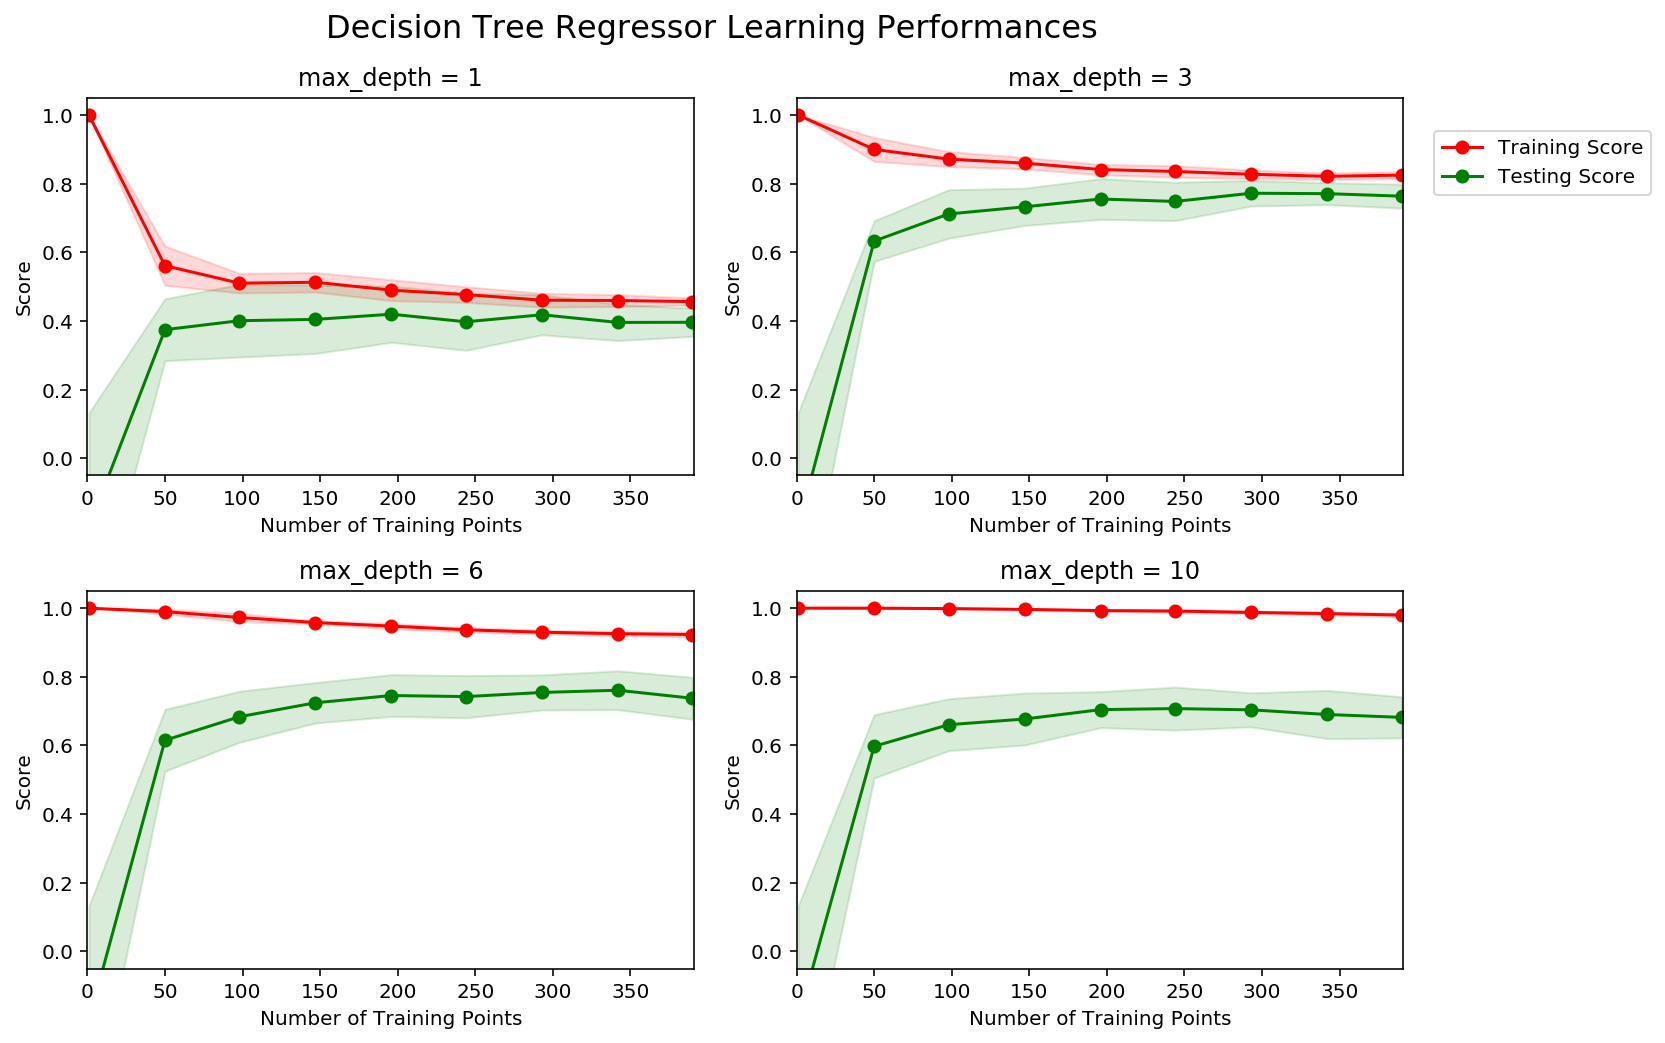

In [7]:
# Produce learning curves for varying training set sizes and maximum depths:
vs.ModelLearning(features, prices)

### Learning the Data

We can now analyze a little the learning curves we have obtained, and, for this, we are going to put a focus on the graph corresponding to a decision tree model with a maximum depth of 3, the one for which it seems the testing score is the best: $R^2$ score $\simeq$ 0.75.

As for the other graphs, we can observe in this one that for a number of training points of 50, the learning curves (both training and testing) begin to stabilize in respect to the $R^2$ score, thus, there is no real benefit to add more and more training points (100 training points appear as enough training points to generate a "good" model).

Furthermore, we can observe on the graph corresponding to a decision tree model with a maximum depth of 3 that the training curve and the testing curve converge towards very close $R^2$ scores, which indicates us that the model is generalizing very well.

The same can be said observing the graph corresponding to a decision tree model with a maximum depth of 1, nevertheless, the obtained $R^2$ scores are worse ($\simeq$ 0.4), therefore, this model is worst than the previous one.

At the opposite, for the graph corresponding to a decision tree model with a maximum depth of 6 and for the graph corresponding to a decision tree model with a maximum depth of 10, the training curve and the testing curve converge, but they converge towards quite far $R^2$ scores: This indicates that these models are overfitting on the training dataset.

For all of these reasons, if we base our analyze only on these graphs, the best model seems to be the one obtained with a decision tree model with a maximum depth of 3.

### Complexity Curves

The following code cell produces a graph for a decision tree model that has been trained and validated on the training data using different maximum depths.

The graph produces two complexity curves — one for training and one for validation.

Similar to the **learning curves**, the shaded regions of both the complexity curves denote the uncertainty in those curves, and the model is scored on both the training and validation sets using the `performance_metric` function.

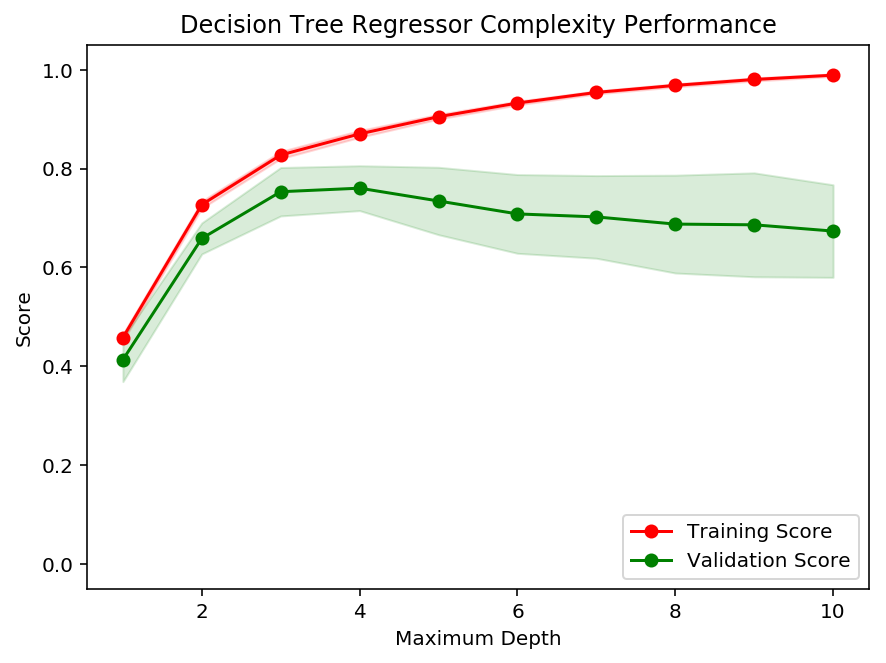

In [8]:
# Produce training and validation complexity curves:
vs.ModelComplexity(X_train, y_train)

### Bias-Variance Tradeoff

Here, we are going to talk about the two extreme models: the decision tree model with a maximum depth of 1 and the decision tree model with a maximum depth of 10.

For the decision tree model with a maximum depth of 1, clearly, the model is not complex enough to pick up the nuances in the data, high bias, a sign of underfitting, can be observed, although the model generalize "well", with a low variance: The training and validation scores are close, but are quite low ($\simeq$ 0.4).

At the opposite, for the decision tree model with a maximum depth of 10, we can observe that the model is unable to generalize well (the training and validation scores are quite far the one from the other), with high variance, a sign of overfitting (the training score is very good, close to 1, meanwhile the validation score is "relatively bad", close to 0.7).

### Best-Guess Optimal Model

Observing the graph above, the two best models seem to be the ones obtained with a decision tree with a maximum depth of 3 and with a decision tree with a maximum depth of 4.

Indeed, we obtained the highest validation scores for these two models, validation scores very close the one from the other ($\simeq$ 0.77).

Nevertheless, we can equally observe that the decision tree model with a maximum depth of 3 generalizes better than the decision tree model with a maximum depth of 4: Indeed, the training and validation scores are closest for this first model.

Therefore, observing the graph above, we can conclude that the best-guess optimal model corresponds to the decision tree model with a maximum depth of 3.

---

## Evaluating Model Performance

In this final section of the project, we are going to construct a model and make a prediction on the client's feature set using an optimized model from `fit_model`.

### Grid Search

Grid search is a technique used in Machine Learning to perform hyperparameter optimization when a model is chosen to modelize a phenomenon object of the study.

Thus, grid search technique evaluates different values of the hyperparameters characterizing the chosen model thanks to a defined and consistent performance metric, and, generally, through cross-validation on the training dataset.

This way, after a grid search technique has been performed, the model hyperparameters which have given the best score on the performance metric can be chosen, as they have defined the best model.

For example, given a phenomenon we want to study, a training dataset characterizing it, the $F_1$ score as the performance metric, and a decision tree model to modelize the phenomenon, a grid search technique would consist in determining the optimized maximum depth to obtained the highest $F_1$ score after, generally, cross-validation on the training dataset.

### Cross-Validation

k-fold cross-validation training technique is generally used with grid search technique.

It consists in dividing the training dataset into k subsets, and, then, to compute the performance metric score using as the validation dataset one of the k subsets and using as the training dataset the k-1 other subsets put together.

This way, k performance metric scores are calculated, and after that, an average value of the performance metric scores is computed.

A general benefit associated with this technique is to help prevent overfitting.

*Nota Bene:* Information on cross-validation in **Scikit-Learn** can be found [here](http://scikit-learn.org/stable/modules/cross_validation.html#cross-validation).

### Fitting a Model

Our final implementation requires that we bring everything together and train a model using the **decision tree algorithm**.

To ensure that, we are going to produce an optimized model, we will train the model using the grid search technique to optimize the `'max_depth'` parameter for the decision tree. The `'max_depth'` parameter can be thought of as how many questions the decision tree algorithm is allowed to ask about the data before making a prediction. Decision trees are part of a class of algorithms called *supervised learning algorithms*.

In addition, we will be using `ShuffleSplit()` for our implementation, for an alternative form of cross-validation (see the `'cv_sets'` variable). While it is not the k-fold cross-validation technique we describe above, this type of cross-validation technique is just as useful! The `ShuffleSplit()` implementation below will create 10 (`'n_splits'`) shuffled sets, and for each shuffle, 20% (`'test_size'`) of the data will be used as the *validation set*.

For the `fit_model` function in the code cell below, we are going to:
- Use [`DecisionTreeRegressor`](http://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeRegressor.html) from `sklearn.tree` to create a decision tree regressor object, and assign this object to the `'regressor'` variable.
- Create a dictionary for `'max_depth'` with the values from 1 to 10, and assign this to the `'params'` variable.
- Use [`make_scorer`](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.make_scorer.html) from `sklearn.metrics` to create a scoring function object, pass the `performance_metric` function as a parameter to the object, and assign this scoring function to the `'scoring_fnc'` variable.
- Use [`GridSearchCV`](http://scikit-learn.org/0.17/modules/generated/sklearn.grid_search.GridSearchCV.html) from `sklearn.grid_search` to create a grid search object, pass the variables `'regressor'`, `'params'`, `'scoring_fnc'`, and `'cv_sets'` as parameters to the object, and assign the `GridSearchCV` object to the `'grid'` variable.

In [9]:
def fit_model(X, y):
    """ Performs grid search over the 'max_depth' parameter for a 
        decision tree regressor trained on the input data [X, y]. """
    
    # Create cross-validation sets from the training data:
    cv_sets = ShuffleSplit(n_splits=10, test_size=0.2)

    # Create a decision tree regressor object:
    regressor = DecisionTreeRegressor()

    # Create a dictionary for the parameter 'max_depth' with a range from 1 to 10:
    params = {'max_depth':list(range(1, 11, 1))}

    # Transform 'performance_metric' into a scoring function using 'make_scorer': 
    scoring_fnc = make_scorer(performance_metric)

    # Create the grid search cv object:
    grid = GridSearchCV(estimator=regressor,
                        param_grid=params,
                        scoring=scoring_fnc,
                        cv=cv_sets)

    # Fit the grid search object to the data to compute the optimal model:
    grid = grid.fit(X, y)

    # Return the optimal model after fitting the data:
    return grid.best_estimator_

### Making Predictions

Once a model has been trained on a given set of data, it can be used to make predictions on new sets of input data.

In the case of a *decision tree regressor*, the model has learned *what the best questions to ask about the input data are*, and can respond with a prediction for the **target variable**.

We can use these predictions to gain information about data where the value of the target variable is unknown — such as data the model was not trained on.

### Optimal Model

Here, we are going to run the code block below to fit the decision tree regressor to the training data and produce an optimal model.

*Nota Bene:* Then, it would be interesting to compare the maximum depth obtained with the one we have guessed some sections above.

In [10]:
# Fit the training data to the model using grid search:
reg = fit_model(X_train, y_train)

# Produce the value for 'max_depth':
print("Parameter 'max_depth' is {} for the optimal model.".format(reg.get_params()['max_depth']))

Parameter 'max_depth' is 4 for the optimal model.


Ultimately, from the result obtained above, we can say that the optimal data tree regressor is the one defined with a maximum depth of 4.

### Predicting Selling Prices

We can now imagine that we are a real estate agent in the Boston area looking to use this model to help to determine the price of homes that our clients wish to sell.

Thus, we have collected the following information from three of our clients:

| Feature | Client 1 | Client 2 | Client 3 |
| :---: | :---: | :---: | :---: |
| Total number of rooms in home | 5 rooms | 4 rooms | 8 rooms |
| Neighborhood poverty level (as %) | 17% | 32% | 3% |
| Student-teacher ratio of nearby schools | 15-to-1 | 22-to-1 | 12-to-1 |

* At what price would we recommend each client to sell his/her home? 
* Do these prices seem reasonable given the values for the respective features? 

*Nota Bene:* Of the three clients, client 3 has the biggest house, in the best public school neighborhood with the lowest poverty level; while client 2 has the smallest house, in a neighborhood with a relatively high poverty rate and not the best public schools.

Now, we are going to run the code block below to have your optimized model make predictions for each client's home.

In [11]:
# Produce a matrix for client data:
client_data = [[5, 17, 15], # Client 1
               [4, 32, 22], # Client 2
               [8, 3, 12]]  # Client 3

# Show predictions:
print("Model's predictions:")
for i, price in enumerate(reg.predict(client_data)):
    print("- Predicted selling price for Client {}'s home: ${:,.2f}".format(i+1, price))

Model's predictions:
- Predicted selling price for Client 1's home: $403,025.00
- Predicted selling price for Client 2's home: $237,478.72
- Predicted selling price for Client 3's home: $931,636.36


These three predicted selling prices are consistent with both the comments in the last *Nota Bene* section and the observations made previously about the features and their respective influence on homes price.

### Sensitivity

An optimal model is not necessarily a robust model. Sometimes, a model is either too complex or too simple to sufficiently generalize to new data. Sometimes, a model could use a learning algorithm that is not appropriate for the structure of the data given. Other times, the data itself could be too noisy or contain too few samples to allow a model to adequately capture the target variable — i.e., the model is underfitted.

Thus, we are going to run the code cell below to run the `fit_model` function ten times with different training and testing sets to see how the prediction for a specific client changes with respect to the data it's trained on.

In [12]:
# Check training dataset influence:
vs.PredictTrials(features, prices, fit_model, client_data)

Sensitivity:

Trial 1: $391,183.33
Trial 2: $411,417.39
Trial 3: $415,800.00
Trial 4: $420,622.22
Trial 5: $413,334.78
Trial 6: $411,931.58
Trial 7: $390,250.00
Trial 8: $407,232.00
Trial 9: $402,531.82
Trial 10: $413,700.00

Range in prices: $30,372.22


### Applicability

To conclude, we can now discuss about the applicability of the model we have just constructed on nowadays real-data settings.

Indeed, the first thing that we can say is that we have built our model thanks to data collected in 1978, more than 40 years ago: Clearly, these data are not relevant anymore (huge inflation, drastic changes in socio-economic realities...), it's a first and strongly reason which makes our model obviously unrelevant for nowadays real-data settings.

Too, we can questioned ourselves about the features: Indeed, are the three features we have used to construct our model sufficient to describe a home and determine its price?

The answer is clearly no, and we can think about numerous other features and aspects which should be taken into account (internet access, energy consumption, surface area, presence of a swimming pool, proximity to working areas, shooping malls, hospitals, sport centers, public transport...).

Now, what about the dataset on which we have constructed our model? As it can be noted in the sensitivity section, range in prices is not insignificant ($\simeq$ \$30,000.00), our model is clearly sensible to the training dataset selection, underfitted, and we can questioned the fact that 489 data points are enough to build a consistent model.

It is equally interesting to note that our model has been built thanks to data collected in an urban city like Boston. In this type of urban cities, general characteristics of entire neighborhoods use to be homogeneous, which makes consistent to grant a significative impact to these neighborhood general characteristics to predict the prices of individual homes belonging to these neighborhoods.

At the opposite, in the case of rural cities, due to a lot of factors (population density, socio-economic conditions of the inhabitants more heterogeneous...), the approach which consists on granting a great impact to general characteristics of entire neighborhoods to predict the prices of individual homes belonging to these neighborhoods is not necessarilly the best.